# Step 1. 인물모드 직접 해 보기

### 루브릭
1. 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다
2. 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다
3. 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## 1. 본인의 인물사진

이미지 사이즈는 (2944, 2208, 3)이다.


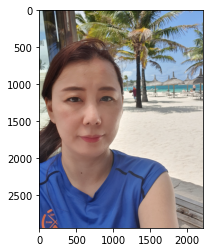

In [2]:
# 이미지 읽어오기
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/me.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print ('이미지 사이즈는 {}이다.'.format(img_orig.shape))

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 세그멘테이션으로 사람 분리하기
 - 이미지 세그멘테이션 : 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법
 - 시멘틱 세그멘티이션 : 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류 *같은 클래스 라벨로 표시(의료 영상 분석, 자율주행)
 - 인스턴스 세그멘테이션 : 시멘틱+ 사람 개개인 별로 다른 라벨 표시, 여러사람이 한 이미지에 등장할때 각 객체 분할해서 인식
 - 기타 : 대부분 인스턴스 라벨이 있는 경우 클래스 라벨도 함께 존재

#### 시멘틱 세그멘테이션 DeepLab 알고리즘
- DeepLab v3+ encoder : separable(=분리가능한) convolution(Xception) + atrous separable convolution(ASSPP) 결합
- DeepLab v3+ decoder : 기존 bilinear upsampling  decoder 부분이 U-Net과 유사한 형태의 decoder로 대체
- 시멘틱 세그멘테이션의 높은 성능을 위해서는 convolutional neural network의 마지막에 존재하는 한 픽셀의 입력값 수용필드가 중요하게 작용
- Atrous convolution 특징 : 필터 내부에 빈공간을 둔 채로 작동하게 됨, r이 커질수록 빈 공간이 넓어짐
- Atrous convolution 활용 : 파라미터 수를 늘리지 않으면서도 수용필드를 크게 키울수 있기 때문에 적극적으로 활용
- Depthwise separable convolution : 기존 convolution filter가 spatial dimension과 channel dimension을 동시에 처리하던 것을 
  따로 분리시켜 각각 처리, 처리에 필요한 파라미터를 하나로 공유함으로써 파라미터의 수를 더 줄일 수 있게 된다.
- 구글 DeepLab Demo : https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):   #전처리
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):   #세그멘티이션을 하는 함수
        img_input = self.preprocess(image) #

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# 사전에 학습된 가중치(pretrained weight)를 불러옵니다
# 구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드하고 DeepLabModel 을 초기화

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir) #디렉토리와 모든 상위/중간 디렉토리를 생성

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path): #지정된 경로가 존재 하는지 여부를 확인하고 없으면 아래 코드 실행
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)  

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력
# DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력

img_resized, seg_map = MODEL.run(img_orig)
print ('원본 이미지 사이즈 : {}\n리사이즈 마스크 크기 : {}\nseg_map.max: {}'.format(img_orig.shape, img_resized.shape, seg_map.max())) 

원본 이미지 사이즈 : (2944, 2208, 3)
리사이즈 마스크 크기 : (513, 384, 3)
seg_map.max: 15


In [6]:
#  구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
print('DeepLab 모델이 구분 할 수 있는 피사체의 개수는 {}개 이다.'.format(len(LABEL_NAMES)))

DeepLab 모델이 구분 할 수 있는 피사체의 개수는 21개 이다.


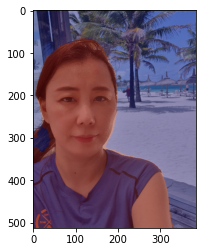

In [7]:
# backgroundf를 제외한 15번째 person

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 person만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

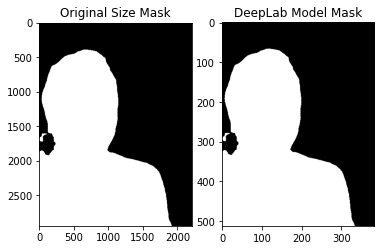

In [8]:
#세그멘테이션 결과(mask)를 원래 크기로 복원
# 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) #더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

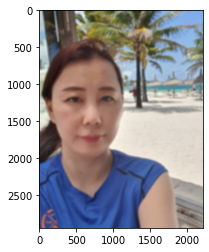

In [9]:
# 배경 흐리게 만들기

img_orig_blur = cv2.blur(img_orig, (30,30)) #(13,13)은 blurring  kernel size를 뜻
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

- blurring  kernel size를 13->30으로 조정 하니 이미지의 흐려짐이 더 강해졌다. 

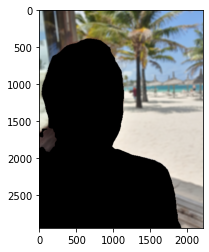

In [10]:
# 세그멘테이션 마스크를 이용해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

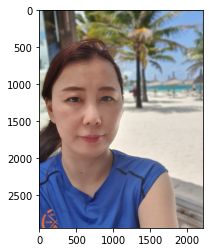

In [11]:
# 배경 영상과 사람 영상 합치기
#  세그멘테이션 마스크가 255인 부분만 원본 영상 가져옴 반대영역은 블러된 미지값을 사용

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 배경의 사물이 밝고, 원근감 있고, 밝은 배경이라 그런지 흐려짐이 많이 티가 나지 않아 blurring  kernel size를 13->30으로 조정 하니 배경의 흐려짐이 더 강해졌다

## 2. 고양이 사진

이미지사이즈는 (472, 474, 3)이다.


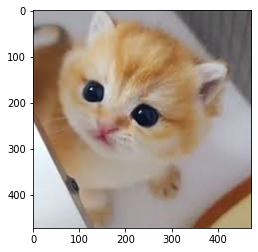

In [12]:
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.JPG'  
cat_img_orig = cv2.imread(cat_img_path) 
print ('이미지사이즈는 {}이다.'.format(cat_img_orig.shape))

plt.imshow(cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력
# DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력

cat_img_resized, seg_map = MODEL.run(cat_img_orig)
print ('원본 이미지 사이즈 : {}\n리사이즈 마스크 크기 : {}\nseg_map.max: {}'.format(cat_img_orig.shape, cat_img_resized.shape, seg_map.max())) 

원본 이미지 사이즈 : (472, 474, 3)
리사이즈 마스크 크기 : (510, 513, 3)
seg_map.max: 8


In [14]:
#  구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
print('DeepLab 모델이 구분 할 수 있는 피사체의 개수는 {}개 이다.'.format(len(LABEL_NAMES)))

DeepLab 모델이 구분 할 수 있는 피사체의 개수는 21개 이다.


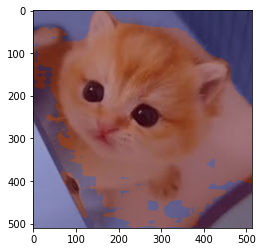

In [15]:
# backgroundf를 제외한 8번째 cat

cat_img_show = cat_img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 cat만 추출
cat_img_mask = seg_map * (255/seg_map.max()) # 255 normalization
cat_img_mask = cat_img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

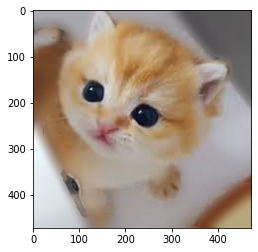

In [16]:
#세그멘테이션 결과(mask)를 원래 크기로 복원
# 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법

cat_img_mask_up = cv2.resize(cat_img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) #더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용
_, cat_img_mask_up = cv2.threshold(cat_img_mask_up, 128, 255, cv2.THRESH_BINARY)

# 고양이 배경 흐리게 만들기
cat_img_orig_blur = cv2.blur(cat_img_orig, (30,30)) #(25,25)은 blurring  kernel size를 뜻합니다. 

# 세그멘테이션 마스크를 이용해서 배경만 추출
cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg_blur = cv2.bitwise_and(cat_img_orig_blur, cat_img_bg_mask)

# 배경 영상과 고양이 영상 합치기
#  세그멘테이션 마스크가 255인 부분만 원본 영상 가져옴 반대영역은 블러된 미지값을 사용

cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur) 
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 고양이와 배경 영역의 경계가 불분명해서 블러처리가 안된곳이 있다.

### 3. 배경전환 크로마키 사진

이미지사이즈는 (1500, 2692, 3)이다.


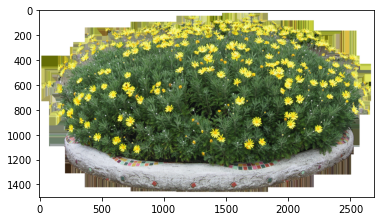

In [17]:
flower_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/flower.png'

flower_orig = cv2.imread(flower_path) 
print ('이미지사이즈는 {}이다.'.format(flower_orig.shape))

plt.imshow(cv2.cvtColor(flower_orig, cv2.COLOR_BGR2RGB))
plt.show()

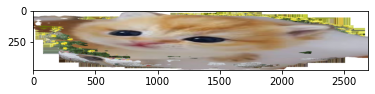

In [32]:
# 이미지, 배경사진, 이미지 mask 리사이즈
cat_resized = cv2.resize(cat_img_orig, (flower_orig.shape[1], cat_img_orig.shape[0]))
flower_resized = cv2.resize(flower_orig, (flower_orig.shape[1], cat_img_orig.shape[0]))

cat_img_mask_resized = cv2.resize(cat_img_mask_color, (flower_orig.shape[1], cat_img_orig.shape[0]))


# 배경 영상과 고양이 영상을 합치기
cat_flower_concat = np.where(cat_img_mask_resized == 255, cat_resized, flower_resized)

plt.imshow(cv2.cvtColor(cat_flower_concat, cv2.COLOR_BGR2RGB))
plt.show()

- cat_img_mask_resized == 255 조정시 고양이 사라짐
- _orig.shape[1] 수정시 그래프 자체가 변경됨

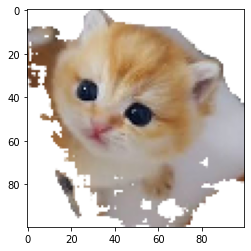

In [19]:
# 고양이 사진 추출 및 리사이즈
just_cat = np.where(cat_img_mask_color==255, cat_img_orig, 255)
just_cat = cv2.resize(just_cat, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(just_cat, cv2.COLOR_BGR2RGB))
plt.show()

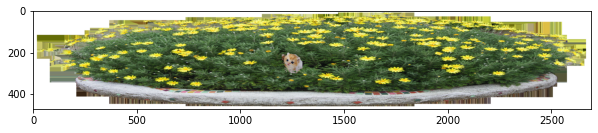

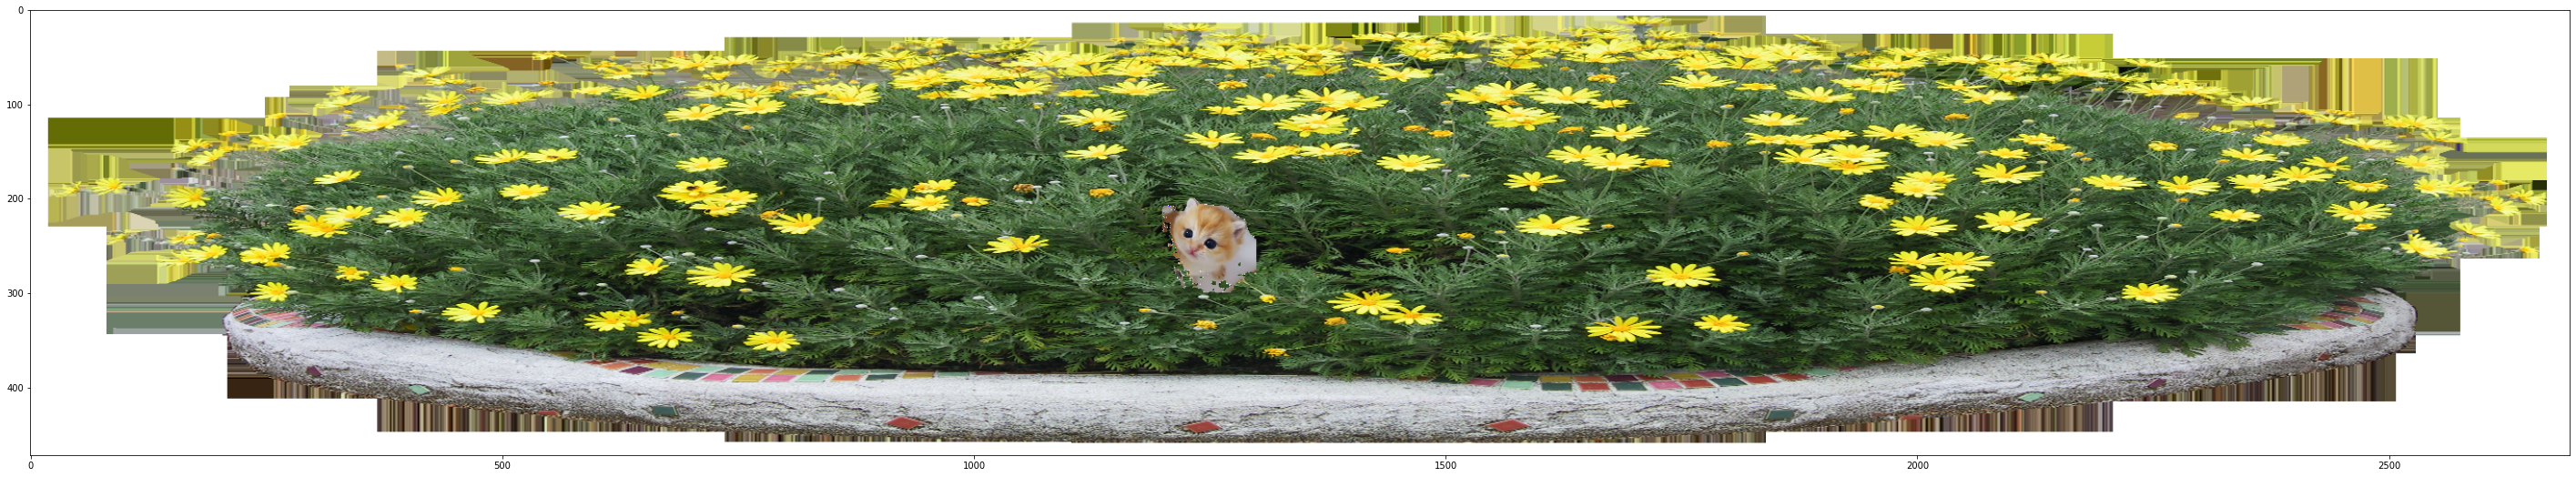

In [39]:
# 리사이즈 사진 위치지정 및 배경과 합성하기
refined_y = 200 
refined_x = 1200

sticker_area = flower_resized[refined_y:refined_y+just_cat.shape[0], refined_x:refined_x+just_cat.shape[1]]
flower_resized[refined_y:refined_y+just_cat.shape[0], refined_x:refined_x+just_cat.shape[1]] = np.where(just_cat==255,sticker_area,just_cat).astype(np.uint8)

plt.figure(figsize=(10,10)) #가로, 세로
plt.imshow(cv2.cvtColor(flower_resized, cv2.COLOR_BGR2RGB))
plt.show()

plt.figure(figsize=(50,50)) #가로, 세로
plt.imshow(cv2.cvtColor(flower_resized, cv2.COLOR_BGR2RGB))
plt.show()


- refined_y, refined_x로 cat 위치 조정 확인
- plt.figure(figsize=(15,15)) ->50,50 으로 했을때 이미지는 확대 되지만 축의 값들은 줄어듬을 확인

# Step 2. 사진에서 문제점 찾기

![1](https://user-images.githubusercontent.com/70866993/129492750-a738f69f-fbec-46bb-9291-999a674b0e20.jpg)
![2](https://user-images.githubusercontent.com/70866993/129492779-60866d27-0fab-4dff-8402-8fa0ca251c27.jpg)
![3](https://user-images.githubusercontent.com/70866993/129492781-3558f218-7d82-49da-a10d-7a1039e69f19.jpg)

<MARK> Step 2.사진에서 문제점 찾기 

1. 내사진
- 왼쪽 머리카락쪽이 인물 영역에 포함되지 않아 blur 미처리 되었다. 
    
2. 고양이 사진
- 일부 영역이 인물 영역에 포함되지 않아 blur 미처리 되었다. 

3. 샘플 사진에서 문제점 찾기
- 이어폰 줄의 일부가 blur처리 되었다. 
- 헤어의 일부가 blur처리 되었다.

# Step 3. 해결 방법을 제안해 보기

<mark><해결 방법 제안>
- 경계선을 찾아주는 DenseCRF(=DeepLab V3) 기술을 활용하여 픽셀 별 객체 존재 확률과 색상을 기준으로 객체의 경계를 명확히 찾아 준다.
    
DenseCRF 이란?
- CRF을 이용하여 CNN의 local 영역만 보는 한계를 개선함, Pixel-by-pixel로 Fully Connected Graph로 연결
- DCNN을 통해 1/8 크기의 coarse score-map을 구한다.이것을 쌍선형 보간법을 통해 원영상 크기로 확대시킴.
- 쌍선형 보간법을 통해 얻어진 결과는 각 픽셀 위치에서의 label에 대한 확률이 되며 이것은 CRF의 unary term에 해당함.
- 최종적으로 모든 픽셀값의 유사도와 위치적인 유사도를 고려한 CRF 후보정 작업을 해주면 최종적인 출력 결과를 얻을 수 있음
- 양선형 보간법 : x축과 y축으로 두번 적용하여 값을 유추하는 방법(네 개의 인접한 점들의 값과 그에 따른 면적을 가중치하여 값을 구하게 된다.)   
    
    
<mark><시도 실패>
- cv2.COLOR_BGR2GRAY 변경, GaussianBlur,cannny Edge 추가 시도  :  이전과 경계와 일부라도 달라진 부분이 없음을 확인 하였다.

<참고>
1. OPEN CV 명함인식 : https://leembedded.tistory.com/22
2. 영상 분할 기법 : https://me2.kr/tgdg7
3. Supervised Semantic Segmentation : https://me2.kr/wyxrg
4. Dense CRF :https://me2.kr/6wdcg
5. 쌍선형보간법 : https://me2.kr/zws3c

# 회고

1. 배경 구분이 쉽지 않다. 포토샵의 경우 깔끔한 블러처리를 위해 확대후 하나의 픽셀마다 처리를 해주는데 비슷한 원리 인것 같다. 
2. 파일 모두 PNG 파일등으로 사용하면 주변 배경이 없어 좀 더 깔끔한 형태로 합성이 될것 같다.
3. 인물배경이 하얀색인 경우 배경이 연한 베이지색, 흰색 배경인 경우 경계구분을 더 못하는것 같다. 흑백도 마찬가지로 확인됨.
4. DenseCRF 기술을 활용하여 객체의 경계를 명확히 찾아준다면 인물 검색할때도 정확도가 높아질것 같다.

<참고>
1. OPEN CV 명함인식 : https://leembedded.tistory.com/22
2. 영상 분할 기법 : https://me2.kr/tgdg7
3. Supervised Semantic Segmentation : https://me2.kr/wyxrg
4. Dense CRF :https://me2.kr/6wdcg
5. 쌍선형보간법 : https://me2.kr/zws3c